In [1]:
from google.colab import drive
import os
drive.mount("/content/gdrive")

os.chdir('/content/gdrive/My Drive/shecode/reference2-paper/')
print(os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/shecode/reference2-paper


In [2]:
# USAGE
# python train_mask_detector.py --dataset dataset

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2

In [3]:
def ShowImage(ImageList, nRows = 1, nCols = 2, WidthSpace = 0.00, HeightSpace = 0.00):    
    from matplotlib import pyplot as plt     
    import matplotlib.gridspec as gridspec        
    
    gs = gridspec.GridSpec(nRows, nCols)         
    gs.update(wspace=WidthSpace, hspace=HeightSpace) # set the spacing between axes.    
    plt.figure(figsize=(20,20))    
    for i in range(len(ImageList)):        
        ax1 = plt.subplot(gs[i])        
        ax1.set_xticklabels([])        
        ax1.set_yticklabels([])        
        ax1.set_aspect('equal') 
        
        plt.subplot(nRows, nCols,i+1) 
        image = ImageList[i].copy()        
        if (len(image.shape) < 3):            
            plt.imshow(image, plt.cm.gray)        
        else:            
            plt.imshow(image)        
            plt.title("Image " + str(i))        
            plt.axis('off') 
    plt.show()

In [4]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = '/content/gdrive/My Drive/shecode/reference2-paper/dataset/'

os.path.exists(imagePaths)

[INFO] loading images...


True

In [5]:
def get_subfiles(dir):
  "Get a list of immediate subfiles"
  return next(os.walk(dir))[2]


In [6]:
# loop over the image paths
data = []
labels = []
for imagePath in os.listdir(imagePaths):
	# extract the class label from the filename
	label = imagePath
	i = 0
	for name in get_subfiles(imagePaths+imagePath):
		# load the input image (224x224) and preprocess it
		i += 1
		img = cv2.imread(imagePaths + imagePath + '/' + name)
		img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
		img = cv2.resize(img, (224, 224))
		img_ = img_to_array(img)
		image = preprocess_input(img_)

		# update the data and labels lists, respectively
		data.append(image)
		labels.append(label)

In [ ]:
# plt.imshow(data[5])

In [10]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
print(len(trainX), len(testX))

1100 275


[INFO] compiling model...
[INFO] training head...
Epoch 1/20
34/34 [==============================] - 15s 434ms/step - loss: 0.3815 - accuracy: 0.8315 - val_loss: 0.0770 - val_accuracy: 0.9818
Epoch 2/20
34/34 [==============================] - 13s 378ms/step - loss: 0.0945 - accuracy: 0.9728 - val_loss: 0.0380 - val_accuracy: 0.9891
Epoch 3/20
34/34 [==============================] - 13s 376ms/step - loss: 0.0554 - accuracy: 0.9878 - val_loss: 0.0292 - val_accuracy: 0.9891
Epoch 4/20
34/34 [==============================] - 13s 379ms/step - loss: 0.0375 - accuracy: 0.9869 - val_loss: 0.0187 - val_accuracy: 0.9927
Epoch 5/20
34/34 [==============================] - 13s 377ms/step - loss: 0.0333 - accuracy: 0.9906 - val_loss: 0.0207 - val_accuracy: 0.9891
Epoch 6/20
34/34 [==============================] - 13s 377ms/step - loss: 0.0172 - accuracy: 0.9963 - val_loss: 0.0213 - val_accuracy: 0.9891
Epoch 7/20
34/34 [==============================] - 13s 380ms/step - loss: 0.0345 - accuracy

NameError: ignored

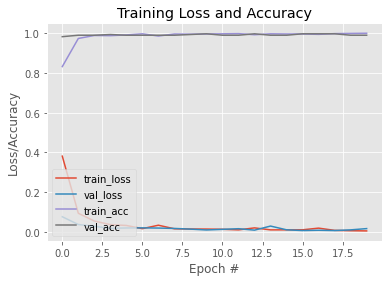

In [11]:
# TRAIN
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save('model.h5')

# serialize model to JSON
# model_json = model.to_json()
# with open("./save_model/model.json", "w") as json_file:
#    json_file.write(model_json)
# serialize weights to HDF5
# model.save_weights("./save_model/model.h5")
print("Saved model to disk")
model.summary()


# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

In [ ]:
# model.summary()

In [13]:
# USAGE
# python detect_mask_image.py --image examples/example_01.png

# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os

print("[INFO] loading face mask detector model...")
model = load_model('model.h5')

[INFO] loading face mask detector model...


In [ ]:
# dataset = []
# # loop over the image paths
# for imagePath in os.listdir(imagePaths):
# 	# extract the class label from the filename
# 	i = 0
# 	print('\n')
# 	for name in get_subfiles(imagePaths+imagePath):
# 		# load the input image (224x224) and preprocess it
# 		i += 1
# 		# print(i, end = ' ')
# 		img = cv2.imread(imagePaths + imagePath + '/' + name)
# 		img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# 		img = cv2.resize(img, (224, 224))
# 		# update the data and labels lists, respectively
# 		dataset.append(img)

# DETECT MASK IMAGE

In [14]:
def ShowImage(ImageList, nRows = 1, nCols = 2, WidthSpace = 0.00, HeightSpace = 0.00):    
  from matplotlib import pyplot as plt     
  import matplotlib.gridspec as gridspec        
    
  gs = gridspec.GridSpec(nRows, nCols)         
  gs.update(wspace=WidthSpace, hspace=HeightSpace) # set the spacing between axes.    
  plt.figure(figsize=(20,20))    
  for i in range(len(ImageList)):        
    ax1 = plt.subplot(gs[i])        
    ax1.set_xticklabels([])        
    ax1.set_yticklabels([])        
    ax1.set_aspect('equal') 
        
    plt.subplot(nRows, nCols,i+1) 
    image = ImageList[i].copy()        
    if (len(image.shape) < 3):            
      plt.imshow(image, plt.cm.gray)        
    else:            
      plt.imshow(image)        
    plt.title("Image " + str(i))        
    plt.axis('off')
  plt.show()

In [15]:
testImg = []
pathPredict = "/content/gdrive/My Drive/shecode/reference2-paper/examples/"
for name in get_subfiles(pathPredict):
	# load the input image (224x224) and preprocess it
	img = cv2.imread(pathPredict + name)
	img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
	testImg.append(img)

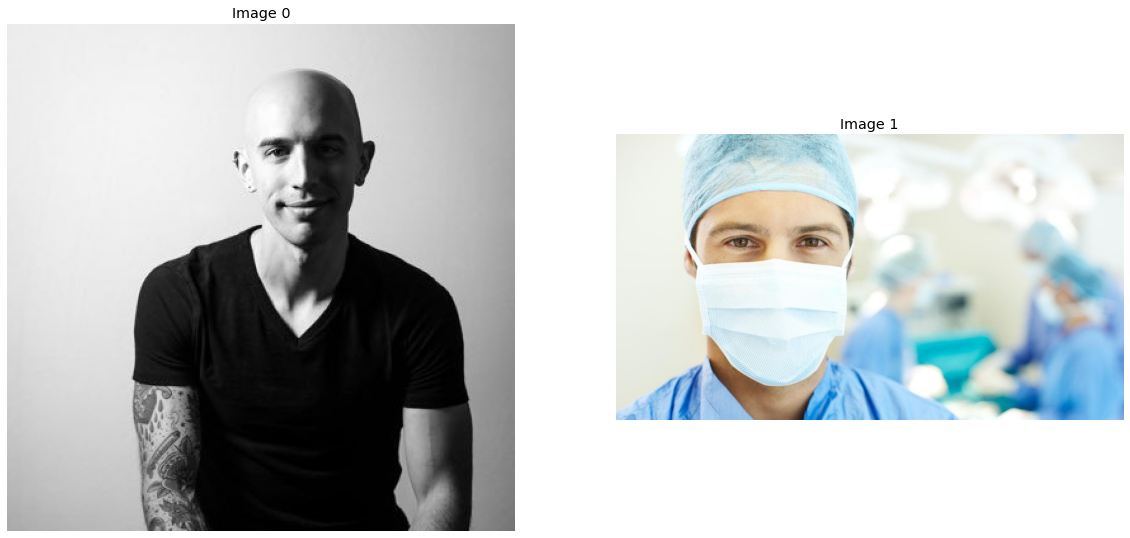

In [16]:
ShowImage(testImg, 1, len(testImg))

In [42]:
# # loop over the detections
# imgRes = []
# image = testImg[1]

# img_org = image.copy()
# plt.imshow(img_org)

In [25]:
# construct a blob from the image
(h, w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")

[INFO] computing face detections...


In [26]:
prototxtPath  = "/content/gdrive/My Drive/shecode/reference2-paper/face_detector/deploy.prototxt"
weightsPath = "/content/gdrive/My Drive/shecode/reference2-paper/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNet(prototxtPath, weightsPath)
net.setInput(blob)
detections = net.forward()

In [40]:
# # loop over the detections
# imgRes = []
# image = testImg[0]
# img_org = image.copy()

for i in range(0, detections.shape[2]):
  # extract the confidence (i.e., probability) associated with
  # the detection
  confidence = detections[0, 0, i, 2]
  # filter out weak detections by ensuring the confidence is
  # greater than the minimum confidence
  if confidence > 0.85: #args["confidence"]:
    # compute the (x, y)-coordinates of the bounding box for
    # the object
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")

    # ensure the bounding boxes fall within the dimensions of
    # the frame
    (startX, startY) = (max(0, startX), max(0, startY))
    (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

    # extract the face ROI, convert it from BGR to RGB channel
    # ordering, resize it to 224x224, and preprocess it
    face = image[startY:endY, startX:endX]
    # face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, (224, 224))
    face = img_to_array(face)
    face = preprocess_input(face)
    face = np.expand_dims(face, axis=0)

    # pass the face through the model to determine if the face
    # has a mask or not
    (mask, withoutMask) = model.predict(face)[0]

    # determine the class label and color we'll use to draw
    # the bounding box and text
    label = "Mask" if mask > withoutMask else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

    # include the probability in the label
    label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

    # display the label and bounding box rectangle on the output
    # frame
    cv2.putText(image, label, (startX, startY - 10),
      cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
  
    print(startX, startY, endX, endY)
    # imgRes.append(img_org)
    # imgRes.append(image)

202 83 577 609


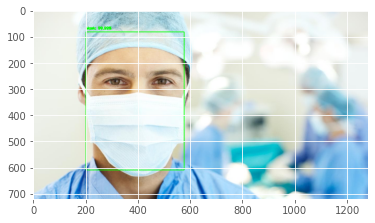

In [41]:
plt.imshow(image)

# DETECT MASK VIDEO

In [ ]:
# USAGE
# python detect_mask_video.py

# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os

def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.05:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

In [ ]:
!pip install ffmpeg-python

from IPython.display import HTML, Javascript, display
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
import ffmpeg

video_file_train = '/content/drive/My Drive/Colab Notebooks/Video Datasets/osy_train.mp4' 
video_file_test = '/content/drive/My Drive/Colab Notebooks/Video Datasets/osy_test.mp4' 
  

VIDEO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var my_btn_txt = document.createTextNode("Press to start recording");

my_btn.appendChild(my_btn_txt);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, videoStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  videoStream = stream;
  var options = {  
    mimeType : 'video/webm;codecs=vp9'  
  };            
  recorder = new MediaRecorder(stream, options);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('video');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({video: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      videoStream.getVideoTracks()[0].stop();
      recordButton.innerText = "Saving the recording... Please wait!"
  }
}

function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def start_webcam():
  js = Javascript('''
    async function startWebcam() {
      const div = document.createElement('div');

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      
      return;

    }
    ''')
  
  display(js)
  frame = eval_js('startWebcam()')
  
    
start_webcam()

def get_video():
  display(HTML(VIDEO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  return binary


In [ ]:
prototxtPath  = "/content/gdrive/My Drive/shecode/reference2-paper/face_detector/deploy.prototxt"
weightsPath = "/content/gdrive/My Drive/shecode/reference2-paper/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)
# faceNet.setInput(blob)
# detections = faceNet.forward()
# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
maskNet = load_model('model.h5')

In [ ]:
# # initialize the video stream and allow the camera sensor to warm up
# print("[INFO] starting video stream...")
# vs = VideoStream(src=0).start()
# time.sleep(2.0)

# loop over the frames from the video stream
webcam = cv2.VideoCapture(0) #Use camera 0
# We load the xml file
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
	(rval, frame) = webcam.read()
	
  # frame=cv2.flip(im,1,1) #Flip to act as a mirror

	# frame = vs.read()
	# frame = imutils.resize(frame, width=400)

  
	# detect faces in the frame and determine if they are wearing a
	# face mask or not
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

	# loop over the detected face locations and their corresponding
	# locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# show the output frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

In [ ]:
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml") 
vs = VideoStream(src=0).start()
start = time.perf_counter() 
data = [] 
time_value = 0
if args["save"]: 
 out = cv2.VideoWriter(path + "liveoutput.avi", cv2.VideoWriter_fourcc('M','J','P','G'), 10, (450,253))